# Init

In [7]:
from pycqed.measurement.waveform_control import circuit_builder as cb_mod
from pycqed.measurement import calibration_points as cp_mod
from pycqed.analysis import analysis_toolbox as a_tools
from pycqed.measurement import sweep_points as sp_mod
from pycqed.utilities import general as gen
from IPython.display import clear_output
from collections import OrderedDict
import matplotlib.pyplot as plt
from importlib import reload
from pprint import pprint
from copy import deepcopy
import numpy as np
import h5py
import os

In [2]:
from pycqed.ATC66_M124_S7P11_virtual import *
from pycqed.measurement import multi_qubit_module as mqm
data_folder = r'C:\Users\Qudev102\Desktop\working_folder\data'
a_tools.datadir = data_folder
clear_output()

In [3]:
from pycqed.instrument_drivers.meta_instrument.qubit_objects import QuDev_transmon as QdvTrmn
QdvTrmn.add_CZ_pulse(qb1, qb4)
qb1.upCZ_qb4_channel('AWG1_ch1')
qb1.upCZ_qb4_aux_channels_dict({})
qbc = qb1
qbt = qb4
cz_pulse_name = f'upCZ {qbt.name} {qbc.name}'


QdvTrmn.add_CZ_pulse(qb1, qb3)
qb1.upCZ_qb3_channel('AWG1_ch1')
qb1.upCZ_qb3_aux_channels_dict({'AWG1_ch4': 0.73})
qbc = qb1
qbt = qb3
cz_pulse_name = f'upCZ {qbt.name} {qbc.name}'


QdvTrmn.add_CZ_pulse(qb2, qb4)
qb2.upCZ_qb4_channel('AWG1_ch2')
qb2.upCZ_qb4_aux_channels_dict({'AWG1_ch5': 0.75})
qbc = qb2
qbt = qb4
cz_pulse_name = f'upCZ {qbt.name} {qbc.name}'


QdvTrmn.add_CZ_pulse(qb2, qb5)
qb2.upCZ_qb5_channel('AWG1_ch2')
qb2.upCZ_qb5_aux_channels_dict({})
qbc = qb2
qbt = qb5
cz_pulse_name = f'upCZ {qbt.name} {qbc.name}'


QdvTrmn.add_CZ_pulse(qb3, qb6)
qb3.upCZ_qb6_channel('AWG1_ch3')
qb3.upCZ_qb6_aux_channels_dict({})
qbc = qb3
qbt = qb6
cz_pulse_name = f'upCZ {qbt.name} {qbc.name}'


QdvTrmn.add_CZ_pulse(qb4, qb6)
qb4.upCZ_qb6_channel('AWG1_ch4')
qb4.upCZ_qb6_aux_channels_dict({'AWG1_ch7': 0.9})
qbc = qb4
qbt = qb6
cz_pulse_name = f'upCZ {qbt.name} {qbc.name}'


QdvTrmn.add_CZ_pulse(qb4, qb7)
qb4.upCZ_qb7_channel('AWG1_ch4')
qb4.upCZ_qb7_aux_channels_dict({'AWG1_ch6': 0.5})
qbc = qb4
qbt = qb7
cz_pulse_name = f'upCZ {qbt.name} {qbc.name}'


QdvTrmn.add_CZ_pulse(qb5, qb7)
qb5.upCZ_qb7_channel('AWG1_ch5')
qb5.upCZ_qb7_aux_channels_dict({})
qbc = qb5
qbt = qb7
cz_pulse_name = f'upCZ {qbt.name} {qbc.name}'

def get_qbaux(qbc, qbt):
    if qbc == qb1 and qbt == qb3:
        qbms = qb4
    elif qbc == qb2 and qbt == qb4:
        qbms = qb5
    elif qbc == qb4 and qbt == qb6:
        qbms = qb7
    elif qbc == qb4 and qbt == qb7:
        qbms = qb6
    else:
        qbms = None
    return qbms

from pycqed.utilities import general as gen
qubits = [qb1, qb2, qb3, qb4, qb5, qb6, qb7]
timestamp = '20200427_233508'
for qb in qubits:
    gen.load_settings(qb, timestamp=timestamp)
clear_output()

# measure_cphase_multi_gates

## Function unwrapped - plot segments

In [51]:
num_cz_gates = 1
leakage_qubits = [qb3, qb2]
ramsey_qubits = [qb1, qb4]

ramsey_phases = np.linspace(0, 2*np.pi, 6)*180/np.pi
sweep_points_2d = sp_mod.SweepPoints()
for qbl, qbr in zip(leakage_qubits, ramsey_qubits):
    # sweep amplitude of each gate (same amps for each gate)
    sweep_points_2d.add_sweep_parameter(f'{CB.get_cz_gate_name(qbl, qbr)}.amplitude',
                                        np.array([0.1247, 0.375]), 'V', 'Pulse amplitude')
    # sweep pulse lengths of each gate (same lengths for each gate)
#     sweep_points_2d.add_sweep_parameter(f'{CB.get_cz_gate_name(qbl, qbr)}.pulse_length', 
#                                         np.array([100e-9, 200e-9]), 's', 'Pulse length')


    

# This code is in the measure function; see detailed comments in multi_qubit_module.py
qubits = leakage_qubits + ramsey_qubits
CB = cb_mod.CircuitBuilder(qubits)
ro_qubits = qubits

sp = sp_mod.SweepPoints()
for qbl, qbr in zip(leakage_qubits, ramsey_qubits):
    sp.add_sweep_parameter(
        f'X90 {qbr.name} 2.phase', np.tile(ramsey_phases, 2),
        'deg', 'Phase, $\\theta$')
    sp.add_sweep_parameter(
        f'X180 {qbl.name} 1.amplitude',
        'lambda sp, amp: amp*np.concatenate([np.ones(len(sp[0]['
            f'"X90 {qbr.name} 2.phase"][0])//2), np.zeros(len(sp[0]['
            f'"X90 {qbr.name} 2.phase"][0])//2)])',
        'V', 'Amplitude, $A$')  
    sp.add_sweep_parameter(
        f'X180 {qbl.name} 2.amplitude',
        f'lambda sp, amp: amp*np.concatenate([np.ones(len(sp[0]['
            f'"X90 {qbr.name} 2.phase"][0])//2), np.zeros(len(sp[0]['
            f'"X90 {qbr.name} 2.phase"][0])//2)])',
        'V', 'Amplitude, $A$')    
sp_2d_temp = deepcopy(sweep_points_2d)
for qbl, qbr in zip(leakage_qubits, ramsey_qubits):        
    for sp2d_name in sweep_points_2d[0]:
        if CB.get_cz_gate_name(qbl, qbr) in sp2d_name:
            sp_info = sp_2d_temp[0].pop(sp2d_name)
            for n in range(num_cz_gates):
                sp_2d_temp[0][
                    f'{CB.get_cz_gate_name(qbl, qbr)} {n+1}.' 
                    f'{sp2d_name.split(".")[-1]}'] = sp_info  
sp += sweep_points_2d    

cal_states = cp_mod.CalibrationPoints.guess_cal_states('auto', for_ef=True)
cp = cp_mod.CalibrationPoints.multi_qubit([qb.name for qb in qubits], cal_states, n_per_state=1)

cz_durations = {
    CB.get_cz_gate_name(q1, q2): num_cz_gates*CB.get_max_cz_gate_duration(q1, q2, sp)
    for q1, q2 in zip(leakage_qubits, ramsey_qubits)}
base_ops = [repr('X180 {qbl.name}'), repr('X90s {qbr.name}')]
base_ops += num_cz_gates*['CB.get_cz_gate_name({qbr.name}, {qbl.name})']
base_ops += [repr('X180 {qbl.name}'), repr('X90s {qbr.name}')]
ops = [eval(op.format(qbl=qbl, qbr=qbr)) for qbl, qbr in
       zip(leakage_qubits, ramsey_qubits) for op in base_ops]
pulses = CB.block_from_ops('B', ops).pulses
pulse_modifs = {i*len(base_ops): {"ref_pulse": "segment_start"}
                for i in range(len(ops)//len(base_ops))}
pulse_modifs.update({ops.index(czn)+num_cz_gates: {"pulse_delay": d, "ref_pulse": pulses[ops.index(czn)-1]['name']}
                     for czn, d in cz_durations.items()})
max_dur_idx = np.argmax([
    CB.get_ops_duration(ops[i*len(base_ops): (i+1)*len(base_ops)])
    for i in range(len(ops)//len(base_ops))])
ro_ref_pulse = pulses[max_dur_idx*len(base_ops): (max_dur_idx+1)*len(base_ops)][-1][
    'name']
sequences, hard_sweep_points, soft_sweep_points = \
    CB.sweep_2d(ops, sp, cp, pulse_modifs=pulse_modifs,
                ro_kwargs={'ref_pulse': ro_ref_pulse,
                           'qb_names': [qb.name for qb in ro_qubits]})

In [52]:
pulse_modifs

{0: {'ref_pulse': 'segment_start'},
 5: {'ref_pulse': 'segment_start'},
 3: {'pulse_delay': 1.58236224e-07, 'ref_pulse': 'X90 qb1 1'},
 8: {'pulse_delay': 9.051170100000001e-08, 'ref_pulse': 'X90 qb4 1'}}

(<Figure size 4800x4500 with 5 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017BB076ABA8>],
       dtype=object))

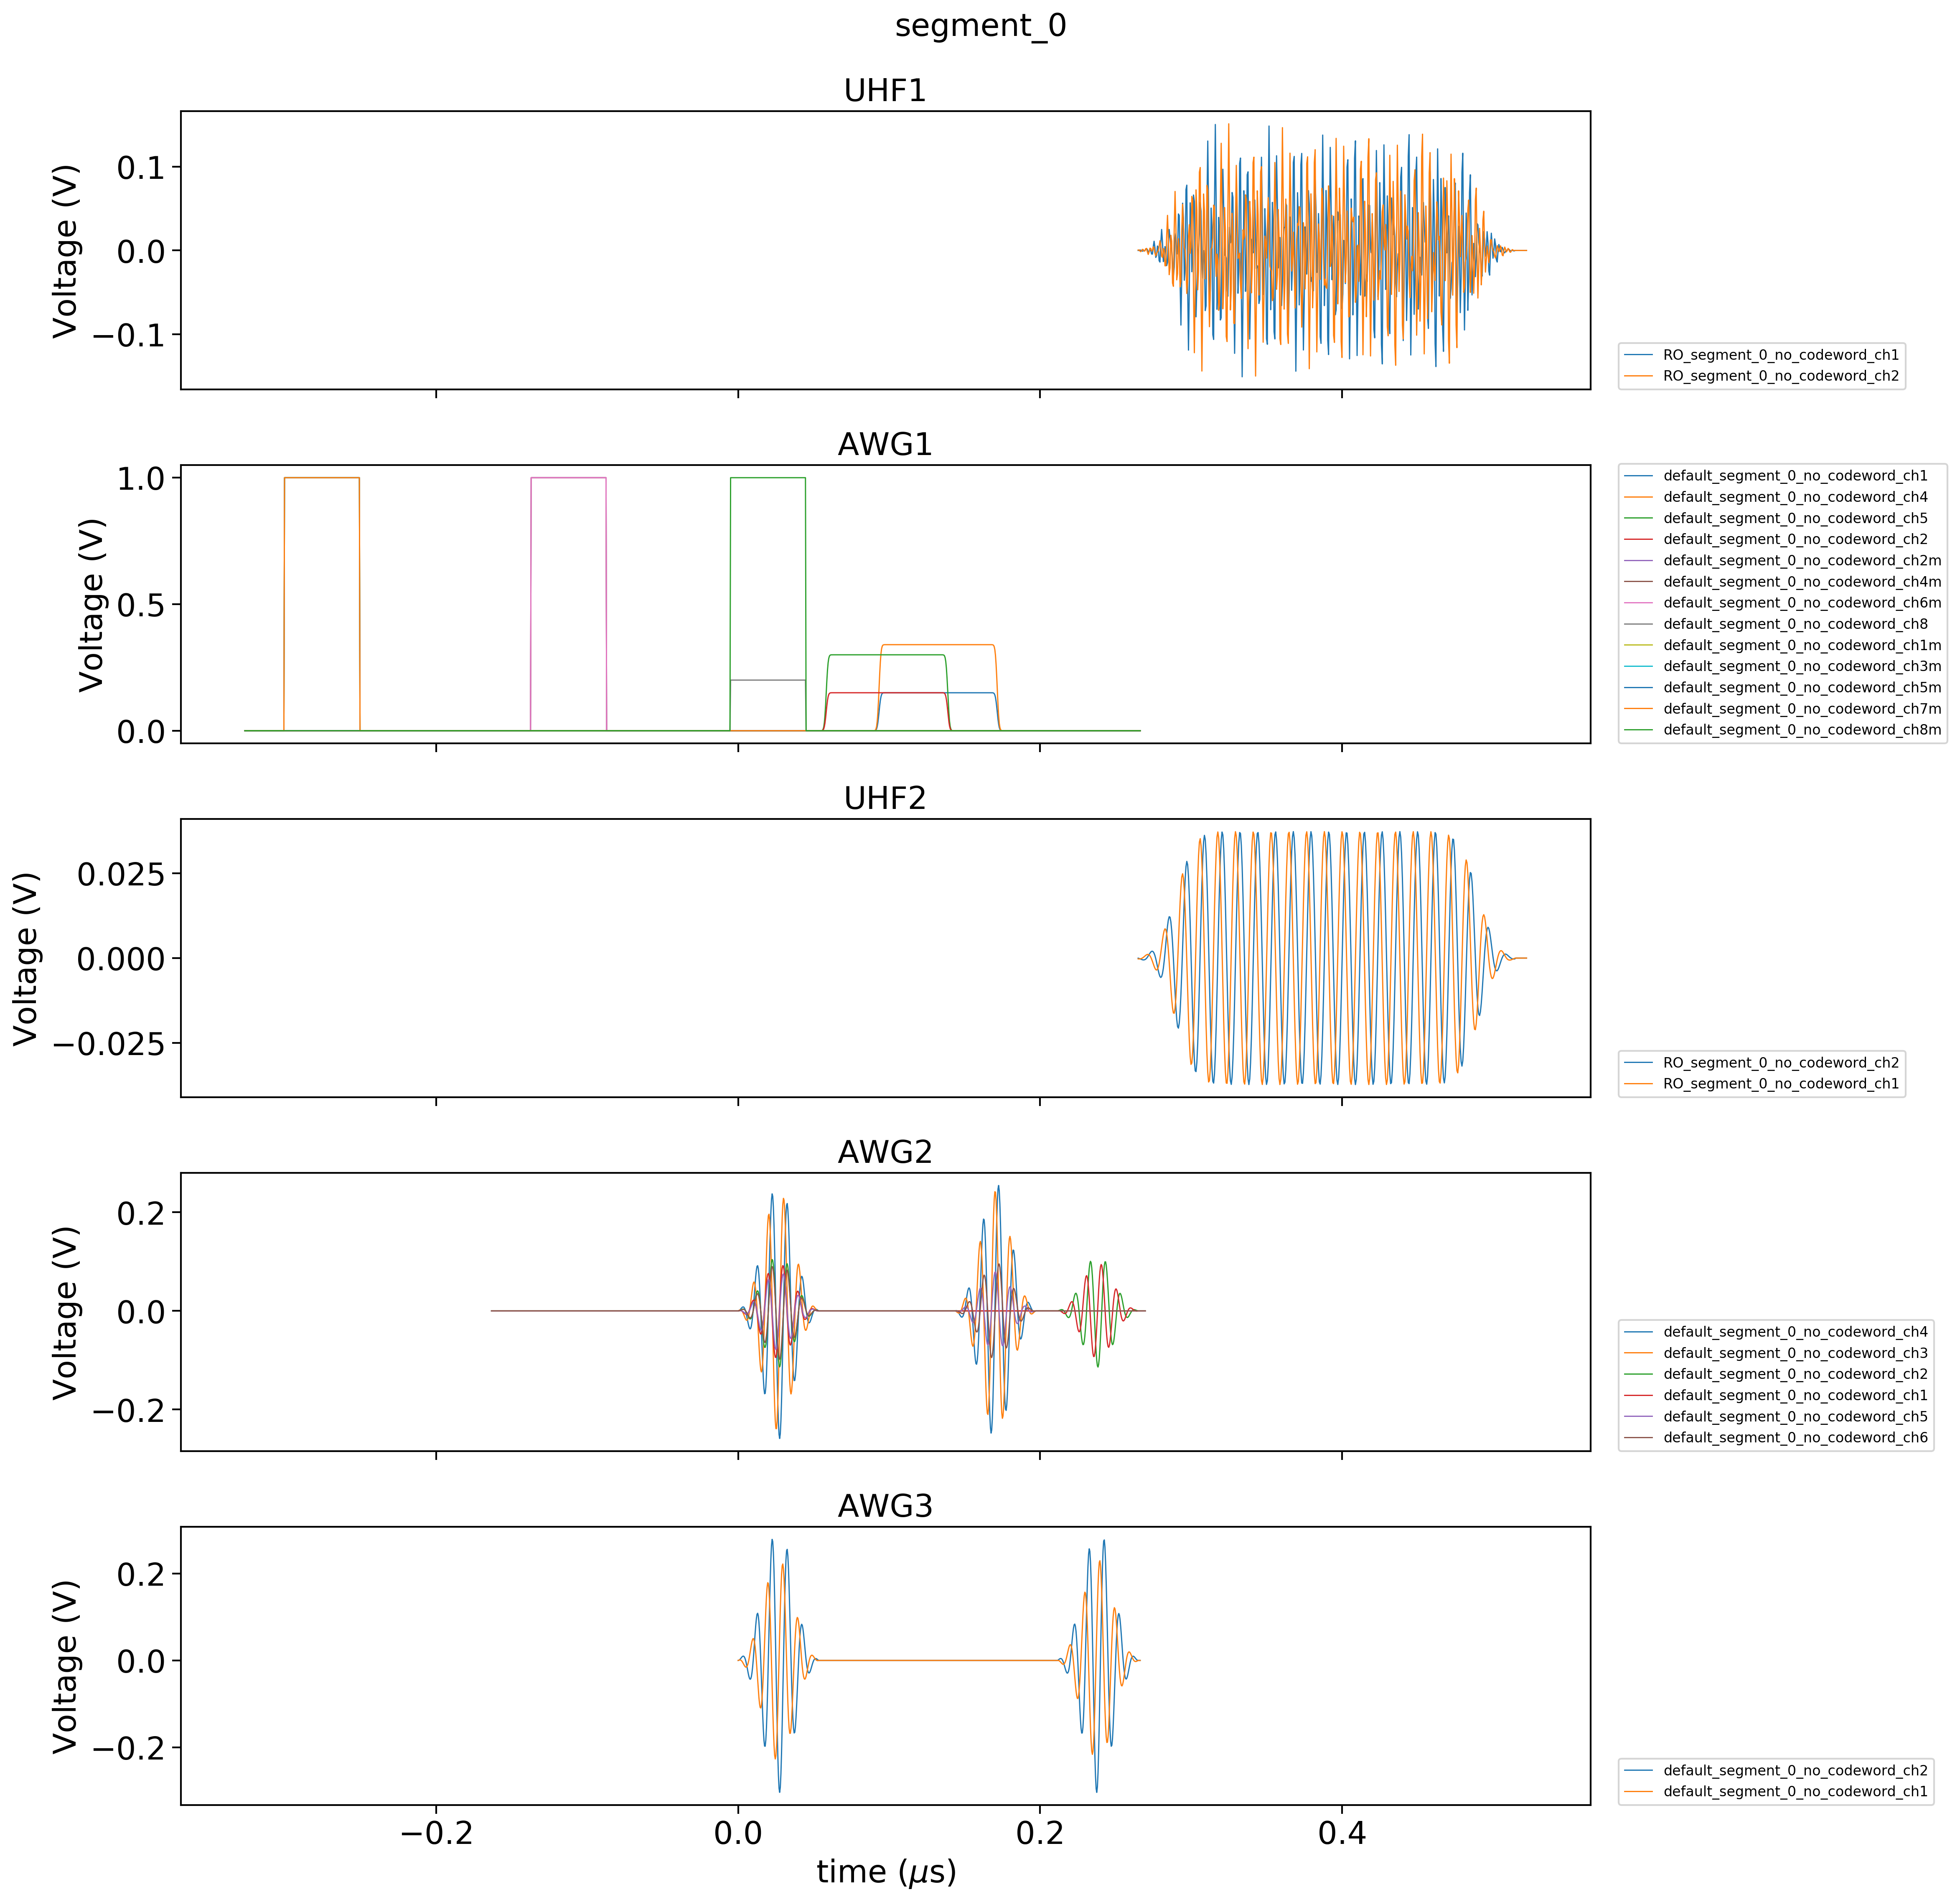

In [53]:
sequences[1].segments['segment_0'].plot()

## Example call

In [18]:
num_cz_gates = 1
leakage_qubits = [qb1, qb2]
ramsey_qubits = [qb3, qb4]
CB = cb_mod.CircuitBuilder(leakage_qubits + ramsey_qubits)

sweep_points_2d = sp_mod.SweepPoints()
for qbl, qbr in zip(leakage_qubits, ramsey_qubits):
    cz_gate_name = CB.get_cz_gate_name(qbl, qbr)
    # sweep amplitude of each gate (same amps for each gate)
    sweep_points_2d.add_sweep_parameter(
        f'{cz_gate_name}.amplitude',
        CB.operation_dict[cz_gate_name]['amplitude'] + np.linspace(-0.005, 0.005, 11),  
        'V', 'Pulse amplitude')
#     sweep pulse lengths of each gate (same lengths for each gate)
    sweep_points_2d.add_sweep_parameter(
        f'{cz_gate_name}.pulse_length', 
        CB.operation_dict[cz_gate_name]['pulse_length'] + np.linspace(-10e-9, 10e-9, 11), 
        's', 'Pulse length')

# Optionals:
ramsey_phases = np.linspace(0, 2*np.pi, 6)*180/np.pi # no need to provide it
max_flux_lengths = {CB.get_cz_gate_name(qbl, qbr): 
                    max(CB.operation_dict[CB.get_cz_gate_name(qbl, qbr)]['pulse_length'] + 
                        np.linspace(-10e-9, 10e-9, 11)) for qbl, qbr in zip(leakage_qubits, ramsey_qubits)}

cphses, leakages, pop_loss, ana_obj = \
    mqm.measure_cphase_multi_gates(leakage_qubits, ramsey_qubits, sweep_points_2d,
                                   max_flux_lengths=max_flux_lengths, ramsey_phases=ramsey_phases,
                                   num_cz_gates=num_cz_gates)